In [118]:
### Chargement des données ###

import pandas as pd
import numpy as np
import re
from collections import Counter,defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from openpyxl import load_workbook
from openpyxl.drawing.image import Image as ExcelImage
from openpyxl.utils.dataframe import dataframe_to_rows
from statistics import stdev


df = pd.DataFrame(columns=['<x>', '<y>','<z>','<t>','gesture', 'subject', 'iter'])

for subject in range(1,11):
    for number in range(0,10):
        for iteration in range(1,11):
            filename = 'Domain1_csv/Subject'+str(subject)+'-'+str(number)+'-'+str(iteration)+'.csv'
            file = pd.read_csv(filename)
            file['gesture'] = number
            file['subject'] = subject
            file['iter'] = iteration
            df = pd.concat([df, file])
df.columns = ['x', 'y', 'z', 't', 'gesture', 'subject', 'iter']

print(df)

C:\Users\User\AppData\Local\Temp\ipykernel_30800\2161041172.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, file])


            x         y         z       t gesture subject iter
0    0.042075  0.036799  0.258380     6.0       0       1    1
1    0.041904  0.037187  0.258505    37.0       0       1    1
2    0.041739  0.037219  0.258619    67.0       0       1    1
3    0.041446  0.037573  0.258731   101.0       0       1    1
4    0.041303  0.037331  0.258830   132.0       0       1    1
..        ...       ...       ...     ...     ...     ...  ...
114  0.126548 -0.070249  0.279681  3832.0       9      10   10
115  0.126768 -0.070271  0.279268  3861.0       9      10   10
116  0.126849 -0.070454  0.278912  3894.0       9      10   10
117  0.126905 -0.070754  0.278601  3928.0       9      10   10
118  0.127055 -0.070855  0.278318  3973.0       9      10   10

[85095 rows x 7 columns]


In [119]:
# recherche de ligne moyenne par geste
grouped = df.groupby(['gesture', 'iter'])
sequence_lengths = grouped.size().reset_index(name='length')
mean_lengths = sequence_lengths.groupby('gesture')['length'].mean()
print("Moyenne du nombre de frames par chiffre :")
for label, mean_len in mean_lengths.items():
    print(f"Chiffre {label} : {mean_len:.2f} frames")

# recherche de durée moyenne par geste
durations = df.groupby(['gesture', 'iter'])['t'].agg(lambda x: x.max() - x.min()).reset_index(name='duration')
mean_durations = durations.groupby('gesture')['duration'].mean()
print("Durée moyenne des gestes (en secondes) par chiffre :")
for gesture, mean_dur in mean_durations.items():
    print(f"Chiffre {gesture} : {mean_dur:.2f} s")

# statistique par geste 
stats = durations.groupby('gesture')['duration'].agg(['mean', 'std', 'min', 'max'])
print(stats)


Moyenne du nombre de frames par chiffre :
Chiffre 0 : 933.70 frames
Chiffre 1 : 938.70 frames
Chiffre 2 : 765.00 frames
Chiffre 3 : 868.80 frames
Chiffre 4 : 846.60 frames
Chiffre 5 : 882.30 frames
Chiffre 6 : 801.00 frames
Chiffre 7 : 517.80 frames
Chiffre 8 : 1081.60 frames
Chiffre 9 : 874.00 frames
Durée moyenne des gestes (en secondes) par chiffre :
Chiffre 0 : 4857.60 s
Chiffre 1 : 4350.10 s
Chiffre 2 : 3353.00 s
Chiffre 3 : 4241.10 s
Chiffre 4 : 4317.50 s
Chiffre 5 : 3981.30 s
Chiffre 6 : 3534.60 s
Chiffre 7 : 2118.60 s
Chiffre 8 : 4925.90 s
Chiffre 9 : 4598.90 s
              mean          std     min     max
gesture                                        
0        4857.5991   783.490300  3943.0  6304.0
1        4350.1000   975.104148  3244.0  6003.0
2        3353.0000   391.220029  2923.0  4242.0
3        4241.1000   466.844597  3675.0  4856.0
4        4317.5000  1341.696211  3455.0  7997.0
5        3981.3000   577.209003  3273.0  4860.0
6        3534.6000   445.572840  3035.0 

C:\Users\User\AppData\Local\Temp\ipykernel_30800\2460047146.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['subject', 'gesture', 'iter'], group_keys=False).apply(standardize_gesture)


          count          mean          std       min         25%          50%  \
x       85095.0  1.405896e-02     0.044954 -0.134073   -0.020228     0.009989   
y       85095.0  7.127629e-03     0.046434 -0.123384   -0.030775     0.007292   
z       85095.0  2.910336e-01     0.056677  0.150242    0.252171     0.289021   
t       85095.0  1.559820e+03  1053.119478  0.000000  710.000000  1424.000000   
x_std   85095.0 -4.154122e-18     0.994113 -3.143829   -0.855973     0.024063   
y_std   85095.0 -1.523874e-18     0.994113 -2.686878   -0.857226    -0.003011   
z_std   85095.0  3.367553e-16     0.994113 -4.138989   -0.814459     0.035817   
t_rank  85095.0  4.717182e+01    31.435185  1.000000   22.000000    43.000000   

                75%          max  
x          0.042703     0.164328  
y          0.047923     0.133097  
z          0.326913     0.525978  
t       2252.000000  7997.000000  
x_std      0.778624     3.290040  
y_std      0.903265     2.485083  
z_std      0.831051     3

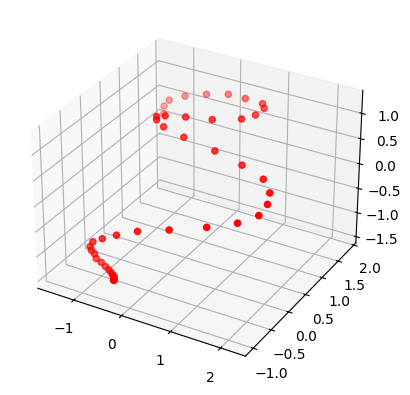

In [120]:
# Fonction de standardisation par trajectoire
def standardize_gesture(df_group):
    df = df_group.copy()
    # Standardisation pour les colonnes 'x', 'y', et 'z' : avec les noms de colonnes sans chevrons
    for axis in ['x', 'y', 'z']:
        df[f'{axis}_std'] = (df[axis] - df[axis].mean()) / df[axis].std()
    return df

# Appliquer la standardisation à chaque trajectoire
df = df.groupby(['subject', 'gesture', 'iter'], group_keys=False).apply(standardize_gesture)
#df = df.groupby(['gesture'], group_keys=False).apply(standardize_gesture)  #par geste uniquement


# Calculer le rang du temps 't' dans chaque groupe
df['t_rank'] = df.groupby(['subject', 'gesture', 'iter'])['t'].rank()

# Afficher les données normalisées d'une trajectoire en 3D
subdf = df.loc[(df['gesture'] == 3) & (df['subject'] == 2) & (df['iter'] == 10)]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(subdf['x_std'], subdf['y_std'], subdf['z_std'], c='r', marker='o')

# Statistiques descriptives
print(df.describe().transpose())

# Sauvegarde CSV
df.to_csv('df.csv', index=False)


In [121]:
#refaire un dico avec 100 ligne chaque fois pour deepL
def resample_gesture(df, target_len=100):
    resampled_data = []

    for (gesture, subject, iter), group in df.groupby(['gesture', 'subject', 'iter']):
        original_len = len(group)
        original_indices = np.arange(original_len)
        target_indices = np.linspace(0, original_len - 1, target_len)

        if original_len < target_len:
            # Interpolation pour séquence courte
            interpolated_x = interp1d(original_indices, group['x_std'], kind='linear')(target_indices)
            interpolated_y = interp1d(original_indices, group['y_std'], kind='linear')(target_indices)
            interpolated_z = interp1d(original_indices, group['z_std'], kind='linear')(target_indices)

        elif original_len > target_len:
            # Sous-échantillonnage pour séquence longue
            interpolated_x = group['x_std'].iloc[target_indices.astype(int)].values
            interpolated_y = group['y_std'].iloc[target_indices.astype(int)].values
            interpolated_z = group['z_std'].iloc[target_indices.astype(int)].values

        else:
            # Exactement 100 points : on garde tel quel
            interpolated_x = group['x_std'].values
            interpolated_y = group['y_std'].values
            interpolated_z = group['z_std'].values

        resampled_df = pd.DataFrame({
            'gesture': [gesture] * target_len,
            'subject': [subject] * target_len,
            'iter': [iter] * target_len,
            'x_std': interpolated_x,
            'y_std': interpolated_y,
            'z_std': interpolated_z,
        })

        resampled_data.append(resampled_df)

    return pd.concat(resampled_data, ignore_index=True)

df100 = resample_gesture(df,100)
print(df100)




       gesture  subject  iter     x_std     y_std     z_std
0            0        1     1  0.565989  0.836985  0.657603
1            0        1     1  0.561907  0.846208  0.665352
2            0        1     1  0.557968  0.846968  0.672419
3            0        1     1  0.550973  0.855382  0.679363
4            0        1     1  0.528174  0.855050  0.691699
...        ...      ...   ...       ...       ...       ...
99995        9       10    10  0.739647 -1.687634 -1.885653
99996        9       10    10  0.741800 -1.697436 -1.903142
99997        9       10    10  0.752100 -1.697934 -1.918776
99998        9       10    10  0.755892 -1.702077 -1.932252
99999        9       10    10  0.765536 -1.711155 -1.954738

[100000 rows x 6 columns]


In [122]:
def dict_creation_iterout(df, iter_out=10):
    # Séparation des données en test et train selon l'itération
    test_df = df[df["iter"] == iter_out]
    train_df = df[df["iter"] != iter_out]

    train_groups = train_df.groupby(["gesture", "subject", "iter"])
    test_groups = test_df.groupby(["gesture", "subject", "iter"])

    coord_dict_train = {}
    for (gesture, subject, _), group in train_groups:
        coords = group[["x_std", "y_std", "z_std"]].values.tolist()
        coord_dict_train.setdefault(gesture, []).append(coords)

    coord_dict_test = {}
    for (gesture, subject, _), group in test_groups:
        coords = group[["x_std", "y_std", "z_std"]].values.tolist()
        coord_dict_test.setdefault(gesture, []).append(coords)
    return coord_dict_train, coord_dict_test


def dict_creation_userout(df, subj_out):
    # Filtrage du sujet test
    test_df = df[df["subject"] == subj_out]
    
    # On garde seulement les 10 premières itérations par geste
    test_df = test_df[test_df["iter"] <= 10]

    # Données d'entraînement
    train_df = df[df["subject"] != subj_out]

    train_groups = train_df.groupby(["gesture", "subject", "iter"])
    test_groups = test_df.groupby(["gesture", "subject", "iter"])

    coord_dict_train = {}
    for (gesture, subject, _), group in train_groups:
        coords = group[["x_std", "y_std", "z_std"]].values.tolist()
        coord_dict_train.setdefault(gesture, []).append(coords)

    coord_dict_test = {}
    for (gesture, subject, _), group in test_groups:
        coords = group[["x_std", "y_std", "z_std"]].values.tolist()
        coord_dict_test.setdefault(gesture, []).append(coords)
    return coord_dict_train, coord_dict_test

def convert_coord_dict_to_xy(DictFunc, df, iter_out):
    """
    Convertit le DataFrame en ensembles X, y pour entraînement et test.
    DictFunc : fonction de création de dictionnaire ('userout' ou 'iterout')
    iter_out : index de test à exclure
    """

    full_dict = DictFunc(df)
    X_train, y_train, X_test, y_test = [], [], [], []

    for gesture in full_dict:
        for subject in full_dict[gesture]:
            for iteration in full_dict[gesture][subject]:
                coords = full_dict[gesture][subject][iteration]

                if DictFunc.__name__ == "dict_creation_iterout" and iteration == iter_out:
                    X_test.append(coords)
                    y_test.append(gesture)
                elif DictFunc.__name__ == "dict_creation_userout" and subject == iter_out:
                    X_test.append(coords)
                    y_test.append(gesture)
                else:
                    X_train.append(coords)
                    y_train.append(gesture)

    return (
        np.array(X_train), np.array(y_train),
        np.array(X_test), np.array(y_test)
    )

In [123]:
# Distance Euclidienne 3D
def eucl_dist(list1, list2):
    return np.sqrt((list1[0] - list2[0])**2 + (list1[1] - list2[1])**2 + (list1[2] - list2[2])**2)

# Distance DTW
def dtw_dist(list1, list2):
    n = len(list1)
    m = len(list2)
    dtw_matrix = np.full((n+1, m+1), np.inf)
    dtw_matrix[0,0] = 0

    for i in range(1,n+1):
        for j in range(1,m+1):
            cost = eucl_dist(list1[i-1], list2[j-1])
            last_min = min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1])
            dtw_matrix[i, j] = cost + last_min

    return dtw_matrix[n,m]

# KNN avec affichage des voisins et votes
def knn_dtw_predict_verbose(reference_seq, train_dict, k=3):
    distances = []

    for gesture, sequences in train_dict.items():
        for seq in sequences:
            dist = dtw_dist(reference_seq, seq)
            distances.append((gesture, dist))

    distances.sort(key=lambda x: x[1])
    k_nearest_neighbors = distances[:k]

    #print(f"\nTop {k} voisins les plus proches (label, distance) :")
    #for i, (gesture, dist) in enumerate(k_nearest_neighbors):
        #print(f"  {i+1}. {gesture} — Distance DTW = {dist:.2f}")

    gestures = [gesture for gesture, _ in k_nearest_neighbors]
    vote_counts = Counter(gestures)

    #print("\nVotes par classe :")
    #for gesture, count in vote_counts.items():
        #print(f"  {gesture} : {count} vote(s)")

    predicted_gesture = vote_counts.most_common(1)[0][0]
    return predicted_gesture

# --------- MODELE LSTM SIMPLE ----------
class LSTMpredict:
    model = None
    df = None
    iter_out = None
    DictFunc = None

    @staticmethod
    def create_model(input_shape=(100, 3), num_classes=10):
        model = models.Sequential([
            layers.LSTM(64, return_sequences=True, dropout=0.2, input_shape=input_shape),
            layers.LSTM(64, dropout=0.3),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(num_classes, activation='softmax')
        ])
        return model

    @classmethod
    def predict(cls, seq):
        if cls.model is None:
            df = cls.df
            iter_out = cls.iter_out
            DictFunc = cls.DictFunc

            train_dict, _ = DictFunc(df, iter_out)

            X_train = []
            y_train = []

            for gesture, sequences in train_dict.items():
                for s in sequences:
                    X_train.append(s)
                    y_train.append(gesture)

            X_train = np.array(X_train, dtype=np.float32)
            y_train = np.array(y_train, dtype=np.int32)

            num_classes = len(set(y_train))
            model = cls.create_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=num_classes)
            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

            cls.model = model

        seq = np.expand_dims(np.array(seq, dtype=np.float32), axis=0)  # (1, 100, 3)
        probs = cls.model.predict(seq, verbose=0)
        return int(np.argmax(probs, axis=1)[0])
    
class CNNpredict:
    model = None
    df = None
    iter_out = None
    DictFunc = None

    @staticmethod
    def build_model(input_shape, num_classes):
        model = Sequential([
            Conv1D(64, 3, activation='relu', input_shape=input_shape),
            MaxPooling1D(2),
            Dropout(0.3),
            Conv1D(128, 3, activation='relu'),
            MaxPooling1D(2),
            Flatten(),
            Dense(64, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    @staticmethod
    def predict(seq):
        # Initialisation du modèle à la première prédiction
        if CNNpredict.model is None:
            df = CNNpredict.df
            iter_out = CNNpredict.iter_out
            DictFunc = CNNpredict.DictFunc

            train_dict, _ = DictFunc(df, iter_out)

            X_train = []
            y_train = []

            for gesture, sequences in train_dict.items():
                for s in sequences:
                    X_train.append(s)
                    y_train.append(gesture)

            X_train = np.array(X_train)
            y_train_cat = to_categorical(y_train, num_classes=10)

            model = CNNpredict.build_model(X_train.shape[1:], 10)
            model.fit(X_train, y_train_cat, epochs=10, batch_size=32, verbose=0)

            CNNpredict.model = model

        # Prédiction
        input_tensor = np.expand_dims(seq, axis=0)  # shape (1, 100, 3)
        y_pred = CNNpredict.model.predict(input_tensor, verbose=0)
        return np.argmax(y_pred, axis=1)[0]

def xgboost_feature_predict(coord_dict_train, coord_dict_test):
    # Construit dataset train et test à partir des dicts créés par DictCreationFunc
    def dict_to_features(coord_dict):
        X, y = [], []
        for gesture, sequences in coord_dict.items():
            for seq in sequences:
                if len(seq) < 5:
                    continue
                # Assure-toi que seq est un np.array (indispensable pour extract_features)
                if not isinstance(seq, np.ndarray):
                    seq = np.array(seq)
                # Pas besoin de preprocess_gesture ici si seq est déjà normalisée / interpolée
                feat = extract_features(seq)
                X.append(feat)
                y.append(gesture)
        return np.array(X), np.array(y)

    X_train, y_train = dict_to_features(coord_dict_train)
    X_test, y_test = dict_to_features(coord_dict_test)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    param = {
        'max_depth': 8,
        'learning_rate': 0.1,
        #'n_estimators': 300,
        'objective': 'multi:softmax',
        'eval_metric': 'mlogloss',
        'lambda': 1.0,
        'alpha': 0.5,
        'num_class': len(np.unique(y_train))
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    bst = xgb.train(param, dtrain, num_boost_round=300)

    y_pred = bst.predict(dtest)
    return y_test, y_pred


# N'oublie pas d'avoir défini cette fonction extract_features avant d'appeler xgboost_feature_predict
# Par exemple :
def extract_features(sequence):
    features = []

    for i in range(3):  # x, y, z
        axis = sequence[:, i]
        features.extend([
            np.mean(axis), np.std(axis), np.min(axis), np.max(axis), np.median(axis),
            np.percentile(axis, 25), np.percentile(axis, 75)
        ])
        fft_vals = np.abs(np.fft.fft(axis))[:10]
        features.extend(fft_vals)

    velocity = np.diff(sequence, axis=0)
    acceleration = np.diff(velocity, axis=0)
    for v in [velocity, acceleration]:
        norms = np.linalg.norm(v, axis=1)
        features.extend([np.mean(norms), np.std(norms), np.max(norms), np.median(norms)])

    distance = np.sum(np.linalg.norm(velocity, axis=1))
    direction = sequence[-1] - sequence[0]
    angle = np.arccos(np.clip(np.dot(direction, [1, 0, 0]) / (np.linalg.norm(direction) + 1e-6), -1, 1))
    features.extend([distance, angle])

    for i in range(1, len(sequence) - 1):
        v1 = sequence[i] - sequence[i - 1]
        v2 = sequence[i + 1] - sequence[i]
        cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-6)
        features.append(np.arccos(np.clip(cos_angle, -1, 1)))

    features.extend([np.mean(features[-(len(sequence) - 2):]), np.std(features[-(len(sequence) - 2):])])

    return np.array(features)


PREF_XGB_CLASSES = {0, 2, 8, 1}
PREF_CNN_CLASSES = {3, 4, 6}

def combined_predict_algo(seq, coord_dict_train, full_dict_test=None):
    # Pour appeler XGBoost dans le bon format
    if full_dict_test is not None and combined_predict_algo.xgb_preds is None:
        _, combined_predict_algo.xgb_preds = xgboost_feature_predict(coord_dict_train, full_dict_test)
        combined_predict_algo.xgb_iter = 0

    # récupérer la prédiction correspondante à l’index
    xgb_pred = combined_predict_algo.xgb_preds[combined_predict_algo.xgb_iter]
    combined_predict_algo.xgb_iter += 1

    # CNN normal
    cnn_pred = CNNpredict.predict(seq)

    # Logique de vote/confidence
    if xgb_pred == cnn_pred:
        return xgb_pred
    elif xgb_pred in [0, 2, 8]:
        return xgb_pred
    elif xgb_pred == 6:
        return cnn_pred
    else:
        return cnn_pred


In [124]:
from collections import defaultdict
from statistics import stdev
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def testmodel(DictCreationFunc, AlgoFunc, df, loop_range=10, k=3, title=None, save_figs=False):
    total_true = []
    total_pred = []
    all_iteration_accuracies = []
    all_top_errors = []
    erreurs_importantes = []

    dict_name = DictCreationFunc.__name__
    algo_name = (
        "LSTM" if AlgoFunc == LSTMpredict.predict else
        "CNN" if AlgoFunc == CNNpredict.predict else
        "KNN-DTW" if AlgoFunc == knn_dtw_predict_verbose else
        "XGBoost" if AlgoFunc == xgboost_feature_predict else
        "Combined" if AlgoFunc == combined_predict_algo else
        "autre"
    )

    for i in range(loop_range):
        coord_dict_train, coord_dict_test = DictCreationFunc(df, i + 1)

        if AlgoFunc == xgboost_feature_predict:
            y_true, y_pred = AlgoFunc(coord_dict_train, coord_dict_test)
            total_true.extend(y_true)
            total_pred.extend(y_pred)
            acc = accuracy_score(y_true, y_pred)
            print(f"\nExactitude pour {dict_name} {i+1} : {acc:.2%}")

        elif AlgoFunc == combined_predict_algo:
            combined_predict_algo.xgb_preds = None
            combined_predict_algo.xgb_iter = 0
            CNNpredict.df = df
            CNNpredict.iter_out = i + 1
            CNNpredict.DictFunc = DictCreationFunc
            CNNpredict.model = None

            y_true = []
            y_pred = []

            for gesture, sequences in coord_dict_test.items():
                for seq in sequences:
                    pred = AlgoFunc(seq, coord_dict_train, full_dict_test=coord_dict_test)
                    if pred is not None:
                        y_true.append(gesture)
                        y_pred.append(pred)
                        total_true.append(gesture)
                        total_pred.append(pred)
                        print(f"Vrai label : {gesture} — Prédiction : {pred}")
                    else:
                        print(f"Erreur de prédiction pour le geste {gesture}, séquence ignorée.")

            accuracy = accuracy_score(y_true, y_pred)
            print(f"\nExactitude pour {dict_name} {i+1} : {accuracy:.2%}")

        else:
            y_true = []
            y_pred = []

            if AlgoFunc == LSTMpredict.predict:
                LSTMpredict.df = df
                LSTMpredict.iter_out = i + 1
                LSTMpredict.DictFunc = DictCreationFunc
                LSTMpredict.model = None

            if AlgoFunc in [CNNpredict.predict, combined_predict_algo]:
                CNNpredict.df = df
                CNNpredict.iter_out = i + 1
                CNNpredict.DictFunc = DictCreationFunc
                CNNpredict.model = None

            if AlgoFunc == CNNpredict.predict:
                CNNpredict.df = df
                CNNpredict.iter_out = i + 1
                CNNpredict.DictFunc = DictCreationFunc
                CNNpredict.model = None

            for gesture, sequences in coord_dict_test.items():
                for seq in sequences:
                    if AlgoFunc in [LSTMpredict.predict, CNNpredict.predict]:
                        pred = AlgoFunc(seq)
                    else:
                        pred = AlgoFunc(seq, coord_dict_train, k=k)

                    if pred is not None:
                        y_true.append(gesture)
                        y_pred.append(pred)
                        total_true.append(gesture)
                        total_pred.append(pred)
                        print(f"Vrai label : {gesture} — Prédiction : {pred}")
                    else:
                        print(f"Erreur de prédiction pour le geste {gesture}, séquence ignorée.")

            accuracy = accuracy_score(y_true, y_pred)
            print(f"\nExactitude pour {dict_name} {i+1} : {accuracy:.2%}")

        # Erreurs par classe
        labels_iter = sorted(set(y_true + y_pred))
        cm_iter = confusion_matrix(y_true, y_pred, labels=labels_iter)
        errors_by_class = defaultdict(float)
        for idx, label in enumerate(labels_iter):
            total = cm_iter[idx].sum()
            correct = cm_iter[idx, idx]
            if total > 0:
                error_rate = 1 - (correct / total)
                errors_by_class[label] = error_rate
                if error_rate > 0.3:
                    erreurs_importantes.append(f"{dict_name} itération {i+1} : {error_rate:.0%} d’erreur sur le geste {label}")

        sorted_errors = sorted(errors_by_class.items(), key=lambda x: x[1], reverse=True)
        top_errors = sorted_errors[:3]
        all_iteration_accuracies.append(accuracy_score(y_true, y_pred))
        all_top_errors.append(top_errors)

        print(f"  ↳ Gestes les plus difficiles à prédire pour {dict_name} {i+1} :")
        for label, err in top_errors:
            print(f"    - Geste {label} : {err:.2%} d’erreur")

    # === Résultat global ===
    accuracy = accuracy_score(total_true, total_pred)
    print(f"\n✅ Exactitude globale : {accuracy:.2%}")

    # === Matrice de confusion globale ===
    labels = sorted(set(total_true + total_pred))
    cm = confusion_matrix(total_true, total_pred, labels=labels)

    full_title = title if title else f"Matrice de confusion - {algo_name} - Dictionnaire : {dict_name} - Classes : {', '.join(map(str, labels))}"
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
    plt.title(full_title)
    plt.grid(False)
    plt.tight_layout()

    if save_figs:
        img_name = f"confusion_{algo_name}_{dict_name}.png"
        plt.savefig(img_name)
        print(f"✅ Image sauvegardée : {img_name}")

    plt.show()

    ecart_type = stdev(all_iteration_accuracies) if len(all_iteration_accuracies) > 1 else 0.0

    return total_true, total_pred, [{
        "modèle": algo_name,
        "split": dict_name,
        "exactitude": accuracy,
        "écart-type": ecart_type,
        "classe la plus confuse": all_top_errors[-1][0][0] if all_top_errors and all_top_errors[-1] else None,
        "erreurs_>30%": "\n".join(erreurs_importantes) if erreurs_importantes else "RAS"
    }]


In [125]:
#testmodel(dict_creation_userout, LSTMpredict.predict, df100, loop_range=10)

In [126]:
#testmodel(dict_creation_userout, knn_dtw_predict_verbose, df, loop_range=10)

In [127]:
#testmodel(dict_creation_userout, CNNpredict.predict, df100, loop_range=10)

In [128]:
#testmodel(dict_creation_userout, xgboost_feature_predict, df100)

In [129]:
#testmodel(dict_creation_userout, combined_predict_algo, df100)


🚀 Lancement pour modèle : XGBoost | Split : dict_creation_iterout

Exactitude pour dict_creation_iterout 1 : 93.00%
  ↳ Gestes les plus difficiles à prédire pour dict_creation_iterout 1 :
    - Geste 4.0 : 10.00% d’erreur
    - Geste 6.0 : 10.00% d’erreur
    - Geste 8.0 : 10.00% d’erreur

Exactitude pour dict_creation_iterout 2 : 98.00%
  ↳ Gestes les plus difficiles à prédire pour dict_creation_iterout 2 :
    - Geste 6.0 : 10.00% d’erreur
    - Geste 0.0 : 0.00% d’erreur
    - Geste 2.0 : 0.00% d’erreur

Exactitude pour dict_creation_iterout 3 : 96.00%
  ↳ Gestes les plus difficiles à prédire pour dict_creation_iterout 3 :
    - Geste 6.0 : 11.11% d’erreur
    - Geste 0.0 : 0.00% d’erreur
    - Geste 2.0 : 0.00% d’erreur

Exactitude pour dict_creation_iterout 4 : 98.00%
  ↳ Gestes les plus difficiles à prédire pour dict_creation_iterout 4 :
    - Geste 0.0 : 0.00% d’erreur
    - Geste 2.0 : 0.00% d’erreur
    - Geste 3.0 : 0.00% d’erreur

Exactitude pour dict_creation_iterout 5 : 9

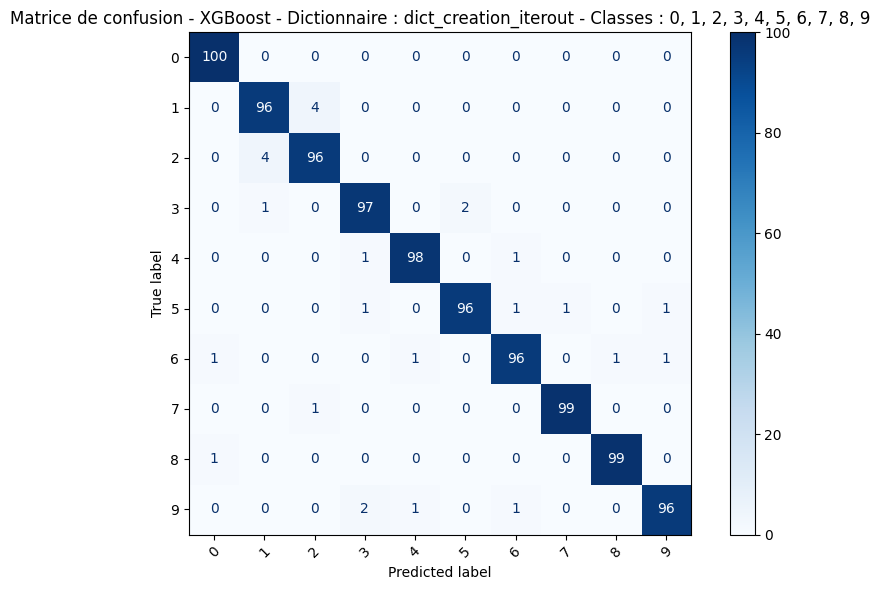


🚀 Lancement pour modèle : XGBoost | Split : dict_creation_userout

Exactitude pour dict_creation_userout 1 : 96.00%
  ↳ Gestes les plus difficiles à prédire pour dict_creation_userout 1 :
    - Geste 0.0 : 0.00% d’erreur
    - Geste 2.0 : 0.00% d’erreur
    - Geste 4.0 : 0.00% d’erreur

Exactitude pour dict_creation_userout 2 : 90.00%
  ↳ Gestes les plus difficiles à prédire pour dict_creation_userout 2 :
    - Geste 0.0 : 0.00% d’erreur
    - Geste 2.0 : 0.00% d’erreur
    - Geste 3.0 : 0.00% d’erreur

Exactitude pour dict_creation_userout 3 : 96.00%
  ↳ Gestes les plus difficiles à prédire pour dict_creation_userout 3 :
    - Geste 0.0 : 0.00% d’erreur
    - Geste 2.0 : 0.00% d’erreur
    - Geste 3.0 : 0.00% d’erreur

Exactitude pour dict_creation_userout 4 : 96.00%
  ↳ Gestes les plus difficiles à prédire pour dict_creation_userout 4 :
    - Geste 6.0 : 10.00% d’erreur
    - Geste 8.0 : 10.00% d’erreur
    - Geste 0.0 : 0.00% d’erreur

Exactitude pour dict_creation_userout 5 : 89.0

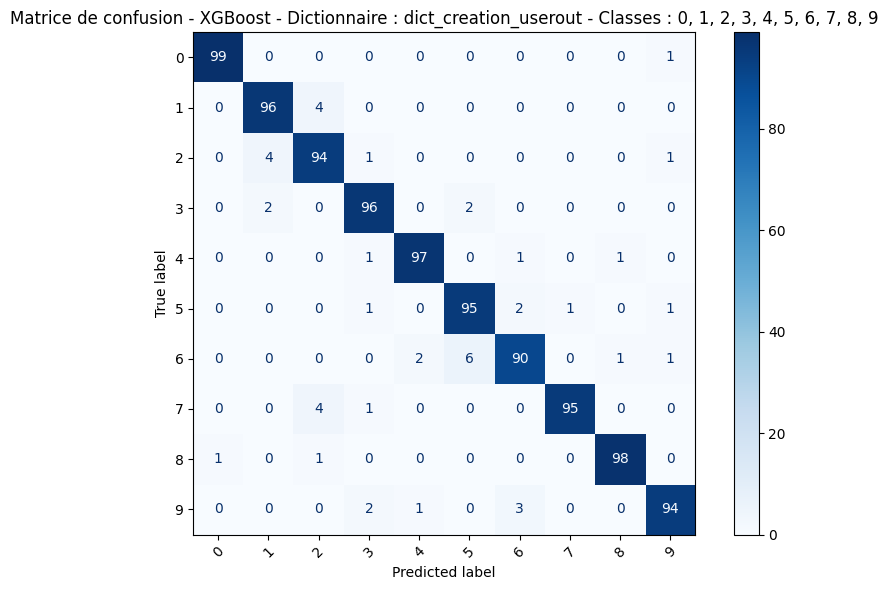


🚀 Lancement pour modèle : LSTM | Split : dict_creation_iterout
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 8
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai lab

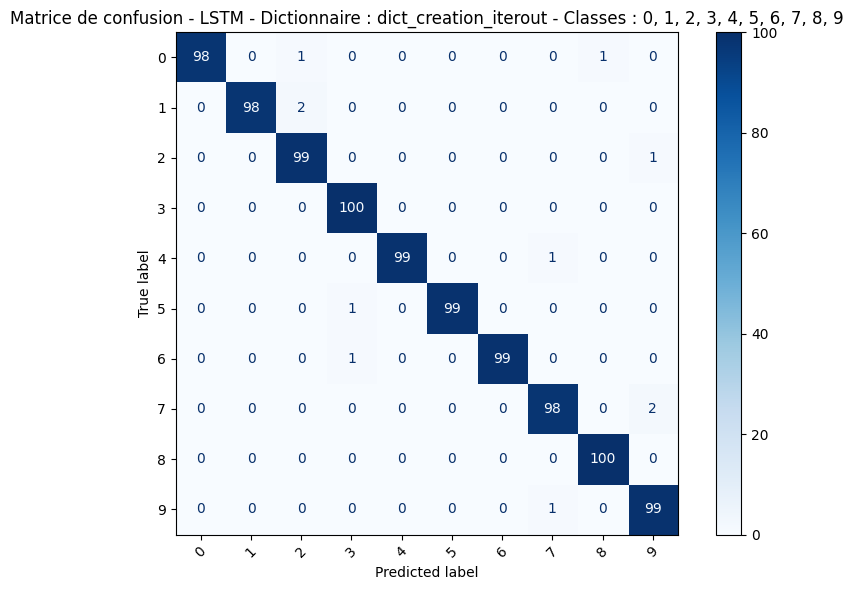


🚀 Lancement pour modèle : LSTM | Split : dict_creation_userout
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 6
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai lab

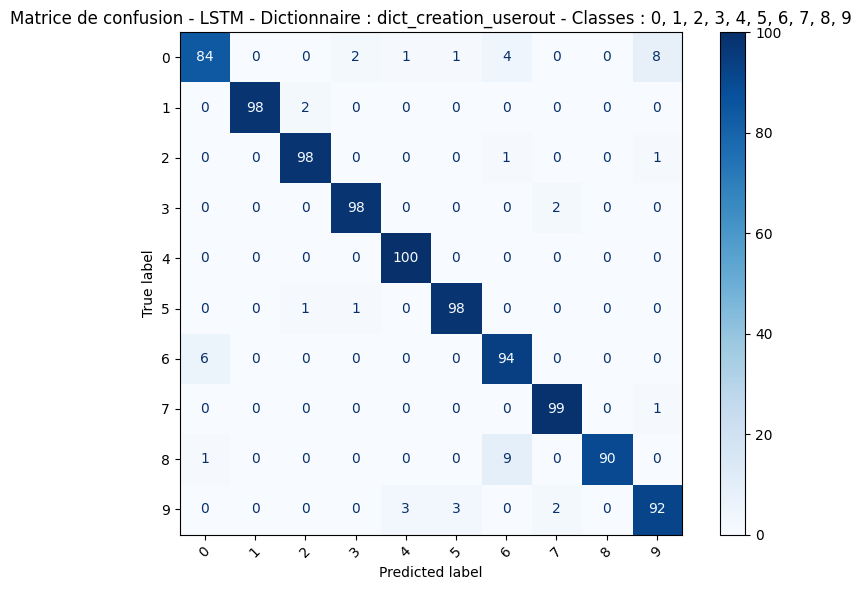


🚀 Lancement pour modèle : CNN | Split : dict_creation_iterout
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 1
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai labe

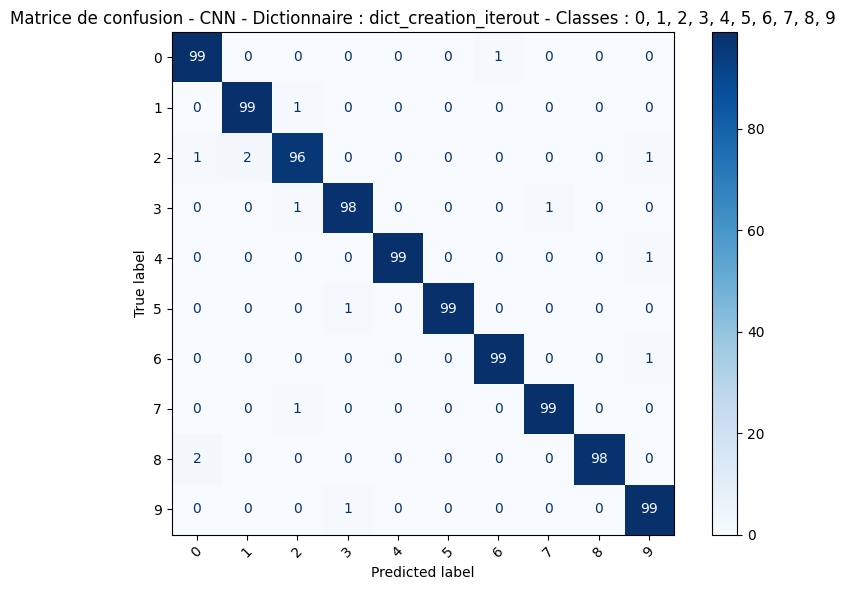


🚀 Lancement pour modèle : CNN | Split : dict_creation_userout
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 8
Vrai label : 0 — Prédiction : 8
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai labe

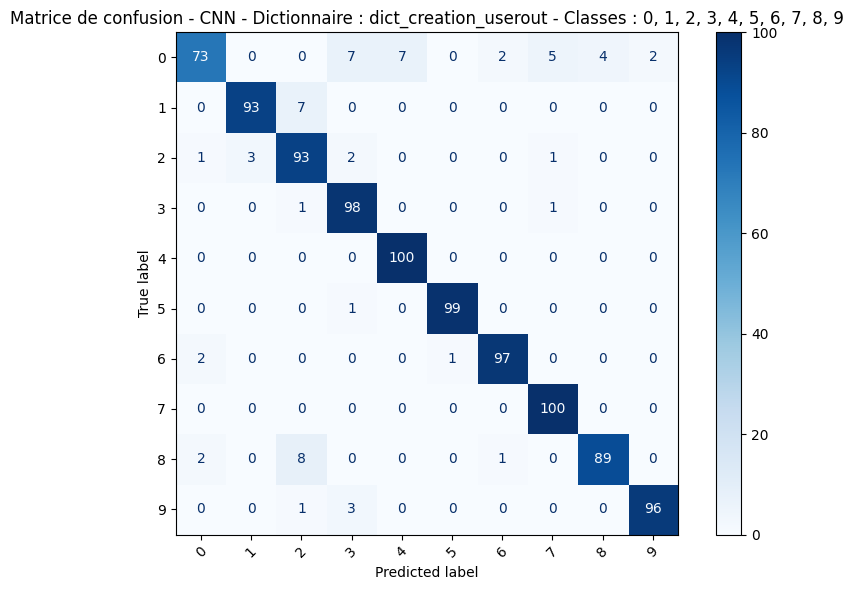


🚀 Lancement pour modèle : KNN-DTW | Split : dict_creation_iterout
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 6
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 2
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai 

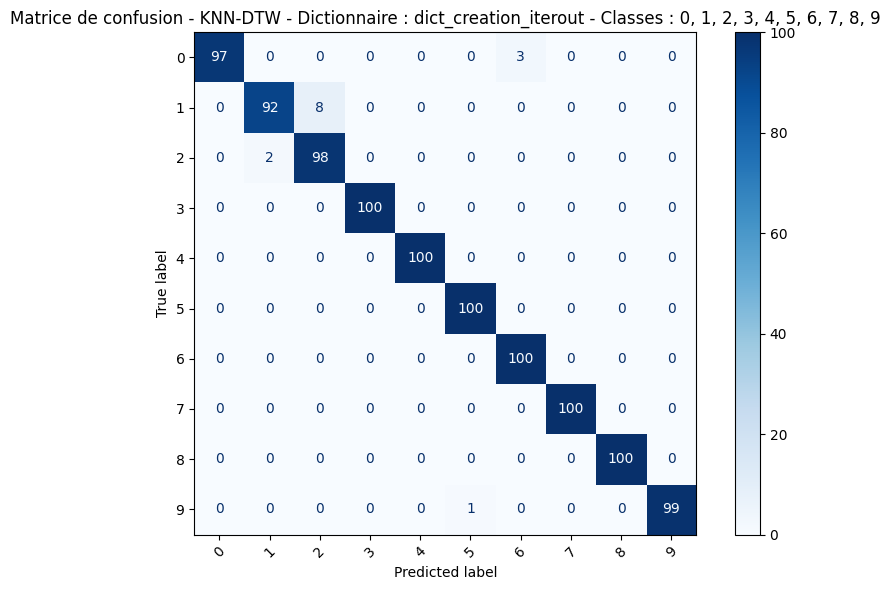


🚀 Lancement pour modèle : KNN-DTW | Split : dict_creation_userout
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 6
Vrai label : 0 — Prédiction : 6
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 0 — Prédiction : 0
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 1 — Prédiction : 1
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai label : 2 — Prédiction : 2
Vrai 

In [ ]:
def run_all_models_and_export(model_configurations, loop_range=10, k=3, excel_filename="rapport_global.xlsx"):
    all_reports = []
    image_paths = []

    for model_name, model_func, dict_func, model_df in model_configurations:
        print(f"\n🚀 Lancement pour modèle : {model_name} | Split : {dict_func.__name__}")
        try:
            total_true, total_pred, report_rows = testmodel(
                DictCreationFunc=dict_func,
                AlgoFunc=model_func,
                df=model_df,
                loop_range=loop_range,
                k=k,
                title=None
            )
            all_reports.extend(report_rows)

            # Ajout du chemin de l'image à intégrer dans Excel
            img_name = f"confusion_{model_name}_{dict_func.__name__}.png"
            image_paths.append(img_name)

        except Exception as e:
            print(f"❌ Erreur pour {model_name} avec {dict_func.__name__} : {e}")

    if all_reports:
        df_all = pd.DataFrame(all_reports)
        with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
            df_all.to_excel(writer, sheet_name='Résultats détaillés', index=False)

            # Résumé global
            df_summary = df_all.groupby(['modèle', 'split']).agg({
                'exactitude': ['mean', 'std'],
                'classe la plus confuse': lambda x: x.value_counts().index[0]
            }).reset_index()
            df_summary.columns = ['Modèle', 'Split', 'Exactitude moyenne', 'Écart-type', 'Classe la plus confuse']
            df_summary.to_excel(writer, sheet_name='Résumé global', index=False)

        print(f"\n📁 Fichier Excel exporté : {excel_filename}")

        # Ajout des images dans le fichier Excel
        wb = load_workbook(excel_filename)
        for i, img_path in enumerate(image_paths):
            try:
                ws = wb.create_sheet(title=f"Confusion {i+1}")
                img = ExcelImage(img_path)
                ws.add_image(img, "A1")
            except Exception as e:
                print(f"Erreur lors de l'ajout de l'image {img_path} : {e}")
        wb.save(excel_filename)
        print("✅ Images ajoutées au fichier Excel.")
        return excel_filename, image_paths
    else:
        print("⚠️ Aucun résultat à exporter.")
        return None, None

# Exemple d'appel corrigé :
models_info = [
    ("XGBoost", xgboost_feature_predict, dict_creation_iterout, df100),("XGBoost", xgboost_feature_predict, dict_creation_userout, df100)
    ,("LSTM", LSTMpredict.predict, dict_creation_iterout, df100),("LSTM", LSTMpredict.predict, dict_creation_userout, df100),
    ("CNN", CNNpredict.predict, dict_creation_iterout, df100),("CNN", CNNpredict.predict, dict_creation_userout, df100),
    ("KNN-DTW", knn_dtw_predict_verbose, dict_creation_iterout, df),("KNN-DTW", knn_dtw_predict_verbose, dict_creation_userout, df),
    ("Combined", combined_predict_algo, dict_creation_iterout, df100),("Combined", combined_predict_algo, dict_creation_userout, df100)]

excel_path, plot_paths = run_all_models_and_export(models_info)

print(f"Excel sauvegardé : {excel_path}")
print(f"Graphiques sauvegardés : {plot_paths}")
